# An Epidemiological Model of Stock Investors

- This notebook is based on the model in [Shiller and Pound (1989)](https://www.sciencedirect.com/science/article/pii/0167268189900760) 

- Author: Tao Wang and Chris Carroll 

- Date: September, 2021


## Introduction

This notebook uses [NDlib](https://ndlib.readthedocs.io/en/latest/#) to simulate the variant described in Carroll and Wang (2021) of the epidemiological model of expectations of [Shiller and Pound (1989)](https://www.sciencedirect.com/science/article/pii/0167268189900760).

We exploit the fact that for a large population, a `random graph` of the kind that the underlying [NetworkX](https://networkx.org) library handles is a good approximation to the discrete-time SIR model, when appropriately parameterized. 



## Model 


- $N$: A large population of investors, divided into three "compartments"
    1. $I_t$: investors who have been "infected" with interest in a certain stock
    2. $S_t$: investors who are "susceptible" to becoming interested in the stock
    3. $R_t$: investors who have been "infected" may "recover" from the infection
       * interpreted as forgetting and losing interest in the stock
- $\beta$: what epidemiologists call the [`infection rate`]()
    * combines the consequences of `random mixing` and the disease transmission upon encounters between $I$ and $S$
         - of course, only the encounter of $S$ and $I$ may have real real consequences. 
    * specifically, 

    \begin{equation}
    \beta =\underbrace{\chi}_{\text{contact rate}} \times \underbrace{\tau}_{\text{transmission probability}}
    \end{equation}
    
    - $\chi$: the number of contacts a person has per time period  
    - $\tau$: the probability of an encounter of an $S$ and an $I$ resulting in the transmission of the infection  

- $\gamma$: recovery rate
    * every infected person recovers with a probability of $\gamma$ per period

Putting these together, the change in the population of infected persons is given by

\begin{equation}
I_{t+1}- I_t = \beta \frac{S_t}{N}I_t - \gamma I_t
\end{equation}

The first term on the right hand side above captures the number of people who "flow" from 'compartment $S$' to 'compartment $I$', which is proportional to the infection rate $\beta$, the fraction of people who are susceptible $\frac{S_t}{N}$, and the number of the infected $I_t$. The second term captures the number of people who "flow" from $I$ to $R$ (See the flow diagram).

Our treatment makes two modifications to the original model as described in Shiller and Pound (1989). First, for consistency with the software toolkit used below, we rewrite their originally continuous-time model in a discrete time form. Second, the original paper described an additional stochastic shock to the change in $I_t$ meant to capture a potential "change in the 'source' of the infection or the nature of the contagion."  Because that shock was not actually used for any results in the paper, we neglect it.

An analytical formula for the limiting size of the compartment $R$ exists under following assumptions. (See the [Wikipedia Page](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology))

   - the basic reproductive ratio $\frac{\beta}{\gamma}$ is strictly greater than 1
   - the initial fraction of the compartment $S_0/N$ is close to 1    
   
See the Appendix for the detailed derivations. 



In [1]:
import ndlib              # 'network dynamics library'
import networkx as nx     # built on top of networkx toolkit
import matplotlib.pyplot as plt
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.bokeh.MultiPlot import MultiPlot
%matplotlib inline
from SIR import SIR, solve_r_ss
import numpy as np

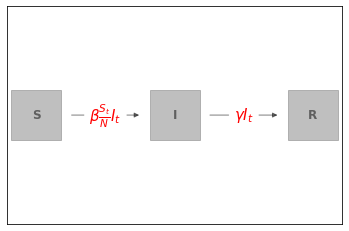

In [2]:
## plot the model 

model = nx.DiGraph()
model.add_edges_from([("S", "I"), ("I", "R")])
#plt.tight_layout()
pos = {'S':(0,1.0),'I':(2,1.0),'R':(4,1.0)}
nx.draw_networkx(model, 
                 pos = pos,
                 arrows=True,
                 node_size = 2500,
                 node_shape ='s',
                 node_color= 'gray',
                 edge_color = 'k',
                 alpha = 0.5,
                 font_color ='k',
                 font_weight = 800
                )
nx.draw_networkx_edge_labels(model,
                             pos,
                             edge_labels={('S','I'):r'$\beta \frac{S_t}{N}I_t$ ',\
                                          ('I','R'):r'$\gamma I_t$'},
                             font_color='red',
                             font_size = 15)

# See if you can add a bit of space between the equations and the boxes
# Add time subscripts in the flow diagram

plt.savefig("./draft/chapter/flow_diagram.png",format="PNG")

To illustrate the model’s implications under such a setting, we parameterize the model with four such combinations of parameter values taken from Shiller and Pound (1989), characterizing two different kinds of investors and two categories of stocks. 
   - 'INSRAND': instutional investors for a randomly selected stock
   - 'INSRPI': instutional investors for a rapidly rising stock
   - 'INDRAND': individual investors for a randomly selected stock 
   - 'INDRPI': individual investors for a rapidly rising stock

### Simulating the SIR model using NDlib 

The toolkit we are using, NDlib, implements a SIR model residing on a given simulated network from another scientific library NetworkX. 

Note that the network-based SIR model does not take the infection rate $\beta$, as a catch-all parameter. Instead, it let the users configure the transmission probability $\tau$ (what the program calls $\beta$, which is not the $\beta$ defined above), and the network structure that affects the contact rates $\chi$, separately. In an N-sized random graph a la Erdos and Renyi (1960) with a connection probability $p$, we have the following relationship 

\begin{equation}
\chi = \underbrace{(N-1)p}_{\text{average degree}}. 
\end{equation}

Hence, we can use the following equation to compute the underlying transmission probability $\tau$ corresponding to the $\beta$ in a random graph parameterized by $N$ and $p$. 

\begin{equation}
 \tau = \frac{\beta}{\chi} = \frac{\beta}{(N-1)p}
\end{equation}

Therefore, we write the following function to compute the value of $\tau$ corresponding to a value of $\beta$ we intend to use, depending on the contact rate $\chi$.

In [3]:
## beta in NDlib is not really beta in standard SIR
## the infection probability tau =  beta in SIR / χ, where χ is the number of contacts 
## χ = = average degree of a random graph =  (N-1) x p 

def beta2tau(beta_sir,
             χ):
    return beta_sir/χ

### Make a random graph 

In [4]:
## create the population residing at a random graph

random_prb = 0.1
population = 8000
degree = random_prb*(population-1)
χ = degree ## number of contacts per period per person is the degree in a random graph 

random_mix = nx.erdos_renyi_graph(population,random_prb)  # agents are randomly connected 

In [5]:
# SIR model to simulate the spread of economic opinions
sir = ep.SIRModel(random_mix)

In [6]:
sir.available_statuses

{'Susceptible': 0, 'Infected': 1, 'Removed': 2}

In [7]:
## simulation periods 
iters = 208

## Shiller and Pound estimates 
types = ['INSRAND','INSRPI','INDRAND','INDRPI']
beta_sir_list = [0.33,0.13,0.22,0.07]
gamma_list = [0.03,0.03,0.07,0.03]
τ_list = [beta2tau(beta_sir,χ) for beta_sir in beta_sir_list]

trends_list =[]


## configurations of the plot
## plot

nb = len(types)

for x in range(nb):
    sir = ep.SIRModel(random_mix)
    cfg_sir = mc.Configuration()
    cfg_sir.add_model_parameter('beta', τ_list[x]) # transmission probability = infection rate/nb of contacts 
    cfg_sir.add_model_parameter('gamma', gamma_list[x]) # removal rate
    cfg_sir.add_model_parameter("fraction_infected", 0.01)
    sir.set_initial_status(cfg_sir)
    
    ## simulate the sir model for a particular configuration 
    iterations = sir.iteration_bunch(iters, node_status=True)
    trends_sir = sir.build_trends(iterations)
    trends_list.append(trends_sir)


### Simulation results 

In [8]:
## some parameters to testing 
beta = 0.1
gamma = 0.03
i0 = 0.01
s0 = 1-i0
r0 = 0.0 
x0 = (s0,i0,r0)
T = iters
times = range(T)

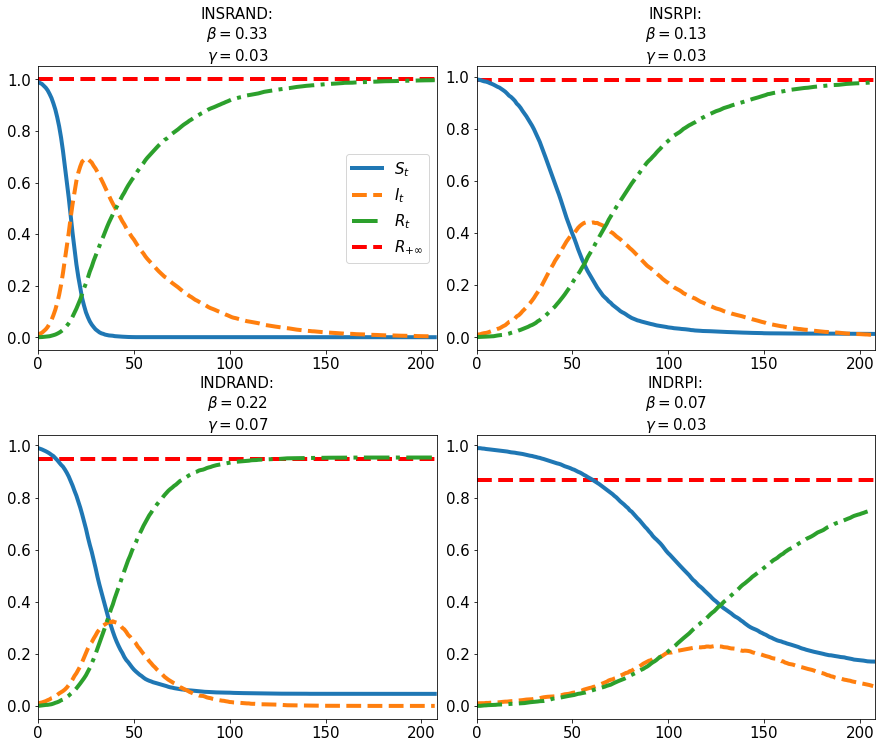

In [10]:
## compare the paths from Ndlib and SIR 

lw = 4
lbsize = 15

## plot
fig, axs = plt.subplots(2,2, 
                        figsize=(15, 12), 
                        facecolor='w', 
                        edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.1)

axs = axs.ravel()
nb = len(types)

nbw1y = 52

for x in range(nb):
    beta = beta_sir_list[x]
    gamma = gamma_list[x]
    s,i,r = SIR(beta, # infection rate
                gamma, # recovery rate 
                T,
                x0)
    title = types[x]+':\n'+r'$\beta={}$'.format(round(beta,2))+'\n'+r'$\gamma ={}$'.format(round(gamma,2))
    axs[x].set_title(title,fontsize=lbsize)
    
    r_ss = solve_r_ss(beta,gamma)
    axs[x].hlines(r_ss,
                      0.0,
                      T,
                      color='r',
                      linestyle ='dashed',
                      lw=lw,
                      label=r'$R_{+\infty}$')

    ### generated from NDlib
    s_nd = np.array(trends_list[x][0]['trends']['node_count'][0])/population
    i_nd = np.array(trends_list[x][0]['trends']['node_count'][1])/population
    r_nd = np.array(trends_list[x][0]['trends']['node_count'][2])/population
    axs[x].plot(times,s_nd,'-',lw=lw,label=r'$S_t$')
    axs[x].plot(times,i_nd,'--',lw=lw,label=r'$I_t$ ')
    axs[x].plot(times,r_nd,'-.',lw=lw,label=r'$R_t$ ')
    
    ### generated from SIR
    #axs[x].plot(times,s,'-',lw=lw,label='S')
    #axs[x].plot(times,i,'--',lw=lw,label='I')
    #axs[x].plot(times,r,'-.',lw=lw,label='R')
    
    axs[x].set_xlim(0.0,T)
    axs[0].legend(loc=0,prop={'size': 15})
    axs[x].tick_params(axis='x', labelsize=lbsize)
    axs[x].tick_params(axis='y', labelsize=lbsize)

plt.savefig("./draft/chapter/figures/sir_simulate.png",format="PNG")

### Appendix. The limiting size 

An analytical formula for the limiting size of the compartment $R$ exists under following assumptions. (See the [Wikipedia Page](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology))

   - the basic reproductive ratio $\frac{\beta}{\gamma}$ is strictly greater than 1
   - the initial fraction of the compartment $S_0/N$ is close to 1    

To obtain the result, we use lower case letter $s_t$, $i_t$, and $r_t$ to represent the fractions of each compartment.

\begin{equation}
\begin{split}
& s_{t+1} - s_{t} = - \beta s_t i_t \\
& i_{t+1}- i_{t} = \beta s_t i_t - \gamma i_t \\
& r_{t+1} - r_t =  \gamma i_t 
\end{split}
\end{equation}

Divide the first equation above by $s_t$ into both sides and further rearrange it. 

\begin{equation}
\begin{split}
&\Delta ln(s_{t+1}) \equiv \frac{s_{t+1} - s_{t}}{s_t} = - \beta i_t \\ 
& \rightarrow i_t = -\frac{\Delta ln(s_{t+1})}{\beta}
\end{split}
\end{equation}

Plug it in the third equation above, we get 

\begin{equation}
\begin{split}
&r_{t+1}- r_t = - \frac{\gamma}{\beta} (ln(s_{t+1})-ln(s_{t})) \\ 
\end{split}
\end{equation}

The equation above holds for any choice of $t$ and $t+\Delta t$, hence we have 

\begin{equation}
\begin{split}
&r_{t+\Delta t}- r_t = - \frac{\gamma}{\beta} (ln(s_{t+\Delta t})-ln(s_{t})) \\ 
\end{split}
\end{equation}

Assuming the initial size of $i_0$ to be infinitely small, hence, $s_0=1$. Plug these $t=0$ values $s_0=1$ and $r_0 =0$, we obtain 

\begin{equation}
\begin{split}
&r_{\Delta t} = \frac{\gamma}{\beta} ln(s_{\Delta t}) \\ 
\end{split}
\end{equation}

Taking the limit of the $\Delta t$ to $+ \infty$, and using the fact that in long run the fraction of the infection $i_{+\infty}=0$, and $1+s_{+\infty}=r_{+\infty}$, we arrive at the folowing equation. 

\begin{equation}
\begin{split}
&r_{+\infty} = - \frac{\gamma}{\beta} ln(1-r_{+\infty}) \\ 
&\leftrightarrow e^{-\frac{\beta}{\gamma} r_{+\infty}} = 1-r_{+\infty}
\end{split}
\end{equation}

$r_{+\infty}$ and $s_{+\infty}$ can be solved. 

Notice that the limiting size does not depend on the specific values of $\beta$ and $\gamma$ but its ratio. 
